In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon

# 1. Charger le NetCDF
ds = xr.open_dataset("era5_t2m_2025_01-02_fr.nc")
var_name = "t2m"

print(ds)

# 2. Extraire les lat/lon
lats = ds["latitude"].values   # (n_lat,)
lons = ds["longitude"].values  # (n_lon,)

# 3. Charger la France (shapefile)
france = gpd.read_file("../data/shapefiles/region.shp")
gdf = france.to_crs("EPSG:4326")

# Union de tous les polygones France
france_poly = gdf.unary_union

# 4. Construire la grille de points centres des pixels
lon2d, lat2d = np.meshgrid(lons, lats)  # lon: axe x, lat: axe y

# Aplatir pour test point-in-polygon
points = [Point(x, y) for x, y in zip(lon2d.ravel(), lat2d.ravel())]

# Lent mais fait une fois, pas par heure
mask_flat = np.array([france_poly.contains(p) for p in points])
mask = mask_flat.reshape(lat2d.shape)  # (n_lat, n_lon)

# 5. Appliquer le masque à tout le champ t2m (toutes les heures)
t2m = ds[var_name]   # (valid_time, latitude, longitude)
t2m_fr = t2m.where(mask)  # NaN en dehors de la France

<xarray.Dataset> Size: 15MB
Dimensions:     (valid_time: 1416, latitude: 43, longitude: 62)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 11kB 2025-01-01 ... 2025-02-28T23...
  * latitude    (latitude) float64 344B 51.5 51.25 51.0 ... 41.5 41.25 41.0
  * longitude   (longitude) float64 496B -5.5 -5.25 -5.0 -4.75 ... 9.25 9.5 9.75
    expver      (valid_time) <U4 23kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 15MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-06T11:41 GRIB to CDM+CF via cfgrib-0.9.1...


/tmp/ipykernel_37215/2239240074.py:22: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_poly = gdf.unary_union


In [2]:
import os

print("CWD :", os.getcwd())
print("Contenu du dossier courant :", os.listdir("."))
print("Contenu du dossier parent :", os.listdir(".."))

CWD : /mnt/data/ProjetMeteo/Analyse_Meteo/tests
Contenu du dossier courant : ['mean_temp.ipynb', 'era5_t2m_2025_01-02_fr.nc', 'test_era5_t2m_20250101_0000.nc', 'era5_t2m_20250101_fr.nc', 'mask.jl', 'plot_temp.ipynb', 'download.py']
Contenu du dossier parent : ['.gitignore', 'tests', '.git', 'Aides-Schémas-Pipelines', '.dvc', 'data', 'data.dvc', '.DS_Store']


In [3]:
print("Dims :", ds.dims)
print("Coords time/valid_time :")
for coord in ds.coords:
    print(coord, ds.coords[coord].shape)

print("Longueur valid_time :", ds[var_name]["valid_time"].shape)
print(ds[var_name]["valid_time"].values[:10])  # pour voir les dates exactes

Dims : FrozenMappingWarningOnValuesAccess({'valid_time': 1416, 'latitude': 43, 'longitude': 62})
Coords time/valid_time :
number ()
valid_time (1416,)
latitude (43,)
longitude (62,)
expver (1416,)
Longueur valid_time : (1416,)
['2025-01-01T00:00:00.000000000' '2025-01-01T01:00:00.000000000'
 '2025-01-01T02:00:00.000000000' '2025-01-01T03:00:00.000000000'
 '2025-01-01T04:00:00.000000000' '2025-01-01T05:00:00.000000000'
 '2025-01-01T06:00:00.000000000' '2025-01-01T07:00:00.000000000'
 '2025-01-01T08:00:00.000000000' '2025-01-01T09:00:00.000000000']


In [4]:
# 6. Conversion en °C
units = ds[var_name].attrs.get("units", "")
if units in ["K", "kelvin"]:
    t2m_fr_c = t2m_fr - 273.15
    units_plot = "°C"
else:
    t2m_fr_c = t2m_fr
    units_plot = units

# 7. Moyenne spatiale à chaque instant
# mean() ignore les NaN par défaut
t2m_mean_series = t2m_fr_c.mean(dim=("latitude", "longitude"))

print(t2m_mean_series)

<xarray.DataArray 't2m' (valid_time: 1416)> Size: 6kB
array([1.7089728, 1.5970751, 1.5445999, ..., 3.5905895, 3.0500236,
       2.560573 ], dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 11kB 2025-01-01 ... 2025-02-28T23...
    expver      (valid_time) <U4 23kB ...


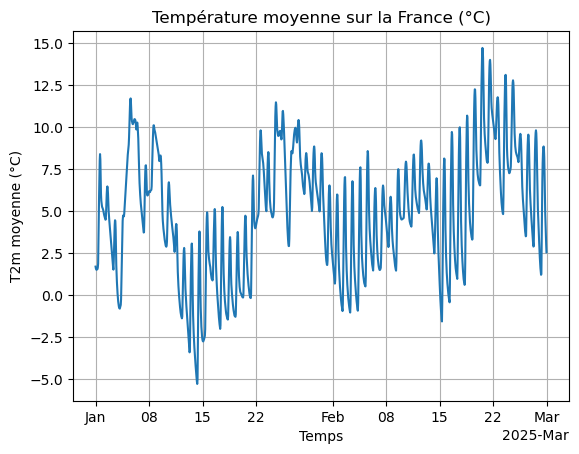

In [5]:
plt.figure()
t2m_mean_series.plot()
plt.title(f"Température moyenne sur la France ({units_plot})")
plt.xlabel("Temps")
plt.ylabel(f"T2m moyenne ({units_plot})")
plt.grid(True)
plt.show()

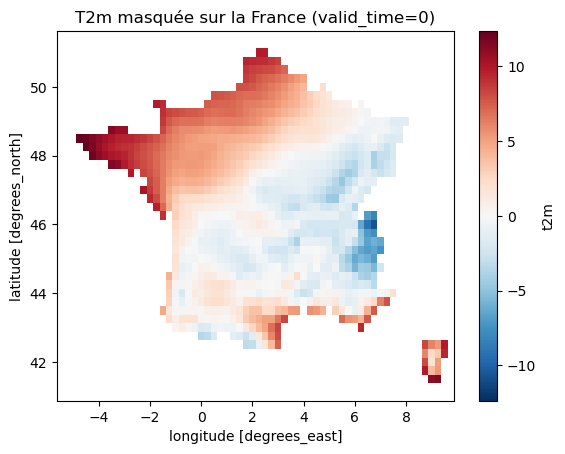

In [6]:
da = t2m_fr_c.isel(valid_time=0)
plt.figure()
da.plot()
plt.title("T2m masquée sur la France (valid_time=0)")
plt.show()

/tmp/ipykernel_37215/3754226271.py:69: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  france_poly_proj = gdf.unary_union  # un seul gros polygone


Poids - min: 0.0 max: 1.0000000000000004 mean: 0.3869137930138202
<xarray.DataArray (valid_time: 1416)> Size: 11kB
array([1.7030892 , 1.59166453, 1.54088484, ..., 3.59851288, 3.0575099 ,
       2.56723547])
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 11kB 2025-01-01 ... 2025-02-28T23...
    expver      (valid_time) <U4 23kB '0001' '0001' '0001' ... '0001' '0001'


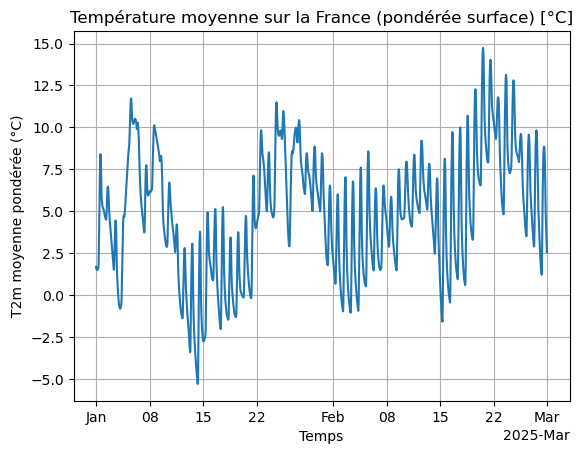

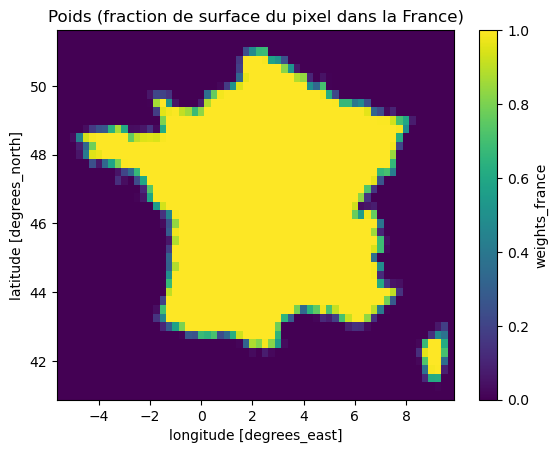

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

# =========================
# 1. Chargement des données
# =========================

# NetCDF ERA5 sur 2 mois (déjà téléchargé)
ds = xr.open_dataset("era5_t2m_2025_01-02_fr.nc")
var_name = "t2m"

# Shapefile France (ton fichier)
france = gpd.read_file("../data/shapefiles/region.shx")

# ===============================
# 2. Fonctions utilitaires
# ===============================

def compute_bounds(coords):
    """
    À partir des coordonnées des centres (1D), calcule les bords (1D) de longueur N+1.
    Marche que les coords soient croissantes ou décroissantes.
    """
    coords = np.asarray(coords)
    N = coords.size
    if N < 2:
        raise ValueError("Il faut au moins 2 points pour calculer des bounds.")

    # Milieux entre deux points successifs
    mids = 0.5 * (coords[:-1] + coords[1:])  # longueur N-1

    bounds = np.empty(N + 1, dtype=float)
    # Borne inférieure : extrapolation à partir du premier point
    bounds[1:-1] = mids
    bounds[0] = coords[0] - (mids[0] - coords[0])
    # Borne supérieure : extrapolation à partir du dernier point
    bounds[-1] = coords[-1] + (coords[-1] - mids[-1])

    return bounds

# ===============================
# 3. Préparation des grilles
# ===============================

# Extraire les lat/lon (centres des pixels)
lats = ds["latitude"].values   # shape (n_lat,)
lons = ds["longitude"].values  # shape (n_lon,)

nlat = len(lats)
nlon = len(lons)

# Calcul des bords lat/lon
lat_bnds = compute_bounds(lats)  # shape (n_lat + 1,)
lon_bnds = compute_bounds(lons)  # shape (n_lon + 1,)

# ===============================
# 4. Préparation des géométries
# ===============================

# CRS
crs_ll = "EPSG:4326"   # lon/lat
crs_proj = "EPSG:2154" # Lambert 93 (mètres, adapté France)

# France en Lambert 93
gdf = france.to_crs(crs_proj)
france_poly_proj = gdf.unary_union  # un seul gros polygone

# ===============================
# 5. Calcul des poids par pixel
# ===============================

weights = np.zeros((nlat, nlon), dtype=float)

for i in range(nlat):
    for j in range(nlon):
        # Polygone du pixel en lon/lat (4 coins)
        corners_ll = [
            (lon_bnds[j],   lat_bnds[i]),
            (lon_bnds[j+1], lat_bnds[i]),
            (lon_bnds[j+1], lat_bnds[i+1]),
            (lon_bnds[j],   lat_bnds[i+1]),
        ]
        cell_poly_ll = Polygon(corners_ll)

        # Projeter le polygone du pixel en Lambert 93
        cell_poly_gs = gpd.GeoSeries([cell_poly_ll], crs=crs_ll).to_crs(crs_proj)
        cell_poly_proj = cell_poly_gs.iloc[0]

        # Intersection avec la France
        inter = cell_poly_proj.intersection(france_poly_proj)

        if inter.is_empty:
            w_ij = 0.0
        else:
            # fraction de surface du pixel qui appartient à la France
            w_ij = inter.area / cell_poly_proj.area

        weights[i, j] = w_ij

# stats des poids
print("Poids - min:", weights.min(), "max:", weights.max(), "mean:", weights.mean())

# ===============================
# 6. Conversion en DataArray xarray
# ===============================

weights_da = xr.DataArray(
    weights,
    coords={"latitude": ds["latitude"], "longitude": ds["longitude"]},
    dims=("latitude", "longitude"),
    name="weights_france"
)

# ===============================
# 7. Température en °C
# ===============================

t2m = ds[var_name]  # (valid_time, latitude, longitude)
units = t2m.attrs.get("units", "")

if units in ["K", "kelvin"]:
    t2m_c = t2m - 273.15
    units_plot = "°C"
else:
    t2m_c = t2m
    units_plot = units

# ===============================
# 8. Moyenne pondérée France
# ===============================

# Numérateur = somme(T * poids) sur l'espace
num = (t2m_c * weights_da).sum(dim=("latitude", "longitude"))

# Dénominateur = somme des poids sur l'espace
# (on ignore les endroits où les données seraient NaN)
den = weights_da.where(
    ~np.isnan(t2m_c.isel(valid_time=0))
).sum(dim=("latitude", "longitude"))

t2m_weighted_mean = num / den  # (valid_time,)

print(t2m_weighted_mean)

# ===============================
# 9. Plot de la courbe moyenne France
# ===============================

plt.figure()
t2m_weighted_mean.plot()
plt.title(f"Température moyenne sur la France (pondérée surface) [{units_plot}]")
plt.xlabel("Temps")
plt.ylabel(f"T2m moyenne pondérée ({units_plot})")
plt.grid(True)
plt.show()

# ===============================
# 10. (Optionnel) Vérifier la carte des poids
# ===============================

plt.figure()
weights_da.plot()
plt.title("Poids (fraction de surface du pixel dans la France)")
plt.show()